In [177]:
!pip install python-louvain
import community
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.metrics import adjusted_rand_score
import random

# Carga de datos

## Catalog

In [178]:
#importo diccionario de areas para saber de donde son los nodos
catalog = pd.read_csv('aal_extended.csv', header=None, index_col=0, squeeze=True)
catalog.columns = ['name', 'number', 'location', 'side']
catalog_dict = catalog.transpose().to_dict()

In [179]:
catalog

name  number   location side
0                                                
1            Precentral_L    2001    Central    L
2            Precentral_R    2002    Central    R
3           Frontal_Sup_L    2101    Frontal    L
4           Frontal_Sup_R    2102    Frontal    R
5       Frontal_Sup_Orb_L    2111    Frontal    L
6       Frontal_Sup_Orb_R    2112    Frontal    R
7           Frontal_Mid_L    2201    Frontal    L
8           Frontal_Mid_R    2202    Frontal    R
9       Frontal_Mid_Orb_L    2211    Frontal    L
10      Frontal_Mid_Orb_R    2212    Frontal    R
11     Frontal_Inf_Oper_L    2301    Frontal    L
12     Frontal_Inf_Oper_R    2302    Frontal    R
13      Frontal_Inf_Tri_L    2311    Frontal    L
14      Frontal_Inf_Tri_R    2312    Frontal    R
15      Frontal_Inf_Orb_L    2321    Frontal    L
16      Frontal_Inf_Orb_R    2322    Frontal    R
17        Rolandic_Oper_L    2331    Central    L
18        Rolandic_Oper_R    2332    Central    R
19      Supp_Motor_Area_L    2401    Frontal    L
20      Supp_Motor_Area_R    2402    Frontal    R
21            Olfactory_L    2501    Frontal    L
22            Olfactory_R    2502    Frontal    R
23   Frontal_Sup_Medial_L    2601    Frontal    L
24   Frontal_Sup_Medial_R    2602    Frontal    R
25      Frontal_Med_Orb_L    2611    Frontal    L
26      Frontal_Med_Orb_R    2612    Frontal    R
27               Rectus_L    2701    Frontal    L
28               Rectus_R    2702    Frontal    R
29               Insula_L    3001     Insula    L
30               Insula_R    3002     Insula    R
..                    ...     ...        ...  ...
87    Temporal_Pole_Mid_L    8211     Limbic    L
88    Temporal_Pole_Mid_R    8212     Limbic    R
89         Temporal_Inf_L    8301   Temporal    L
90         Temporal_Inf_R    8302   Temporal    R
91      Cerebelum_Crus1_L    9001  Cerebelum    L
92      Cerebelum_Crus1_R    9002  Cerebelum    R
93      Cerebelum_Crus2_L    9011  Cerebelum    L
94      Cerebelum_Crus2_R    9012  Cerebelum    R
95          Cerebelum_3_L    9021  Cerebelum    L
96          Cerebelum_3_R    9022  Cerebelum    R
97        Cerebelum_4_5_L    9031  Cerebelum    L
98        Cerebelum_4_5_R    9032  Cerebelum    R
99          Cerebelum_6_L    9041  Cerebelum    L
100         Cerebelum_6_R    9042  Cerebelum    R
101        Cerebelum_7b_L    9051  Cerebelum    L
102        Cerebelum_7b_R    9052  Cerebelum    R
103         Cerebelum_8_L    9061  Cerebelum    L
104         Cerebelum_8_R    9062  Cerebelum    R
105         Cerebelum_9_L    9071  Cerebelum    L
106         Cerebelum_9_R    9072  Cerebelum    R
107        Cerebelum_10_L    9081  Cerebelum    L
108        Cerebelum_10_R    9082  Cerebelum    R
109            Vermis_1_2    9100  Cerebelum   --
110              Vermis_3    9110  Cerebelum   --
111            Vermis_4_5    9120  Cerebelum   --
112              Vermis_6    9130  Cerebelum   --
113              Vermis_7    9140  Cerebelum   --
114              Vermis_8    9150  Cerebelum   --
115              Vermis_9    9160  Cerebelum   --
116             Vermis_10    9170  Cerebelum   --

[116 rows x 4 columns]

## DataSujetos

In [180]:
# leo archivos y dejo todos los datos en un dataframe
filenames = glob.glob('DataSujetos/*')

#df = pd.DataFrame(columns = list(catalog['name']) + ['estadio', 'sujeto'])
sujetos_df = pd.DataFrame()

for file in filenames:
    # Leo archivo de un sujeto y un estadio
    df_from_file = pd.read_csv(file, header= None)
    #df_from_file.columns = list(catalog['name'])
    
    # Fomate el df 
    estadio, sujeto = file.replace('.csv', '').split('_')
    estadio = estadio.split('\\')[1]
    #estadio = estadio.split('/')[1]
    df_from_file['estadio'] = estadio
    df_from_file['sujeto'] = sujeto
    
    #df_from_file = df_from_file.set_index(catalog['name'])
    
    # Appendeo el archivo cargado
    sujetos_df = sujetos_df.append(df_from_file)

In [181]:
sujetos_df.shape

(8352, 118)

In [182]:
sujetos_df

0         1        2        3        4         5        6  \
0    1.000000  0.858200  0.74820  0.69050  0.56056  0.509860  0.78675   
1    0.858200  1.000000  0.66561  0.70798  0.59563  0.581730  0.69447   
2    0.748200  0.665610  1.00000  0.78922  0.68111  0.528150  0.86555   
3    0.690500  0.707980  0.78922  1.00000  0.61537  0.730370  0.81926   
4    0.560560  0.595630  0.68111  0.61537  1.00000  0.721480  0.69519   
5    0.509860  0.581730  0.52815  0.73037  0.72148  1.000000  0.63407   
6    0.786750  0.694470  0.86555  0.81926  0.69519  0.634070  1.00000   
7    0.670460  0.710250  0.71271  0.93598  0.62785  0.801710  0.84643   
8    0.626660  0.514570  0.60522  0.51765  0.51788  0.463590  0.61158   
9    0.516140  0.508490  0.55609  0.61433  0.70201  0.787300  0.63560   
10   0.692790  0.656150  0.57916  0.64571  0.49541  0.475540  0.74518   
11   0.546280  0.652330  0.51100  0.73450  0.58971  0.723190  0.67279   
12   0.730700  0.637840  0.76605  0.65433  0.64769  0.532210  0.84152   
13   0.574010  0.625250  0.56140  0.77029  0.56793  0.721940  0.68188   
14   0.607920  0.530240  0.68073  0.50946  0.57178  0.445900  0.67755   
15   0.552790  0.593760  0.56065  0.63245  0.66685  0.703560  0.61831   
16   0.593970  0.688370  0.47970  0.53224  0.38196  0.386190  0.57636   
17   0.576400  0.747090  0.43983  0.60394  0.37473  0.474120  0.56194   
18   0.615520  0.593670  0.49533  0.57594  0.19726  0.313210  0.56894   
19   0.598370  0.727860  0.42022  0.62459  0.31112  0.503900  0.53555   
20   0.503250  0.594390  0.54400  0.58489  0.41233  0.336640  0.48054   
21   0.324410  0.436330  0.42350  0.44287  0.36248  0.280080  0.34783   
22   0.579060  0.522380  0.89028  0.69707  0.55192  0.395000  0.70846   
23   0.631120  0.607850  0.85698  0.81942  0.62195  0.564260  0.73514   
24   0.300740  0.157100  0.55682  0.28609  0.22353  0.038454  0.32233   
25   0.563980  0.527040  0.77661  0.65386  0.71305  0.578650  0.69903   
26   0.339100  0.296240  0.54656  0.29140  0.78243  0.435110  0.49217   
27   0.474590  0.422700  0.66094  0.49157  0.79638  0.580920  0.58183   
28   0.562490  0.645750  0.44400  0.59499  0.45114  0.579880  0.63635   
29   0.409370  0.581550  0.31142  0.60106  0.37355  0.581940  0.51264   
..        ...       ...      ...      ...      ...       ...      ...   
86   0.501480  0.469770  0.67651  0.63350  0.62236  0.634830  0.60292   
87   0.596760  0.584210  0.66934  0.66003  0.65925  0.673800  0.63978   
88   0.552030  0.574390  0.67889  0.67793  0.55937  0.613240  0.67858   
89   0.671160  0.685100  0.66196  0.65863  0.62056  0.648930  0.67527   
90   0.362290  0.436230  0.61365  0.61892  0.46748  0.596410  0.58252   
91   0.451610  0.498230  0.70533  0.67962  0.60795  0.678400  0.66440   
92   0.317760  0.368630  0.63731  0.62694  0.47775  0.585430  0.58361   
93   0.331850  0.359180  0.64744  0.61703  0.49515  0.593250  0.58092   
94   0.318760  0.369670  0.54774  0.56458  0.40268  0.575210  0.48823   
95   0.197560  0.224350  0.40626  0.41159  0.25787  0.418600  0.34273   
96   0.299010  0.405440  0.57548  0.61072  0.44707  0.620140  0.50573   
97   0.261820  0.336110  0.53537  0.55171  0.40134  0.573870  0.47088   
98   0.194430  0.310320  0.54896  0.57148  0.38741  0.528800  0.47562   
99   0.496260  0.573370  0.64227  0.63703  0.58907  0.682010  0.63022   
100  0.306840  0.368860  0.57019  0.57819  0.44537  0.578590  0.52223   
101  0.227780  0.294410  0.57717  0.59300  0.41491  0.564190  0.50202   
102  0.184570  0.264010  0.54224  0.54872  0.37715  0.517770  0.46665   
103  0.168390  0.246790  0.55064  0.57905  0.38467  0.541940  0.45851   
104  0.036798  0.137870  0.45018  0.49758  0.30076  0.449890  0.34759   
105  0.142680  0.246650  0.51194  0.56770  0.34804  0.528810  0.43204   
106  0.106960  0.202500  0.41239  0.40198  0.28058  0.378250  0.34787   
107  0.115940  0.210190  0.50069  0.54181  0.31151  0.485130  0.41239   
108  0.035310  0.101300  0.36090  0.41647  0.16604  0.406720  0.28508 

## Visualizacion

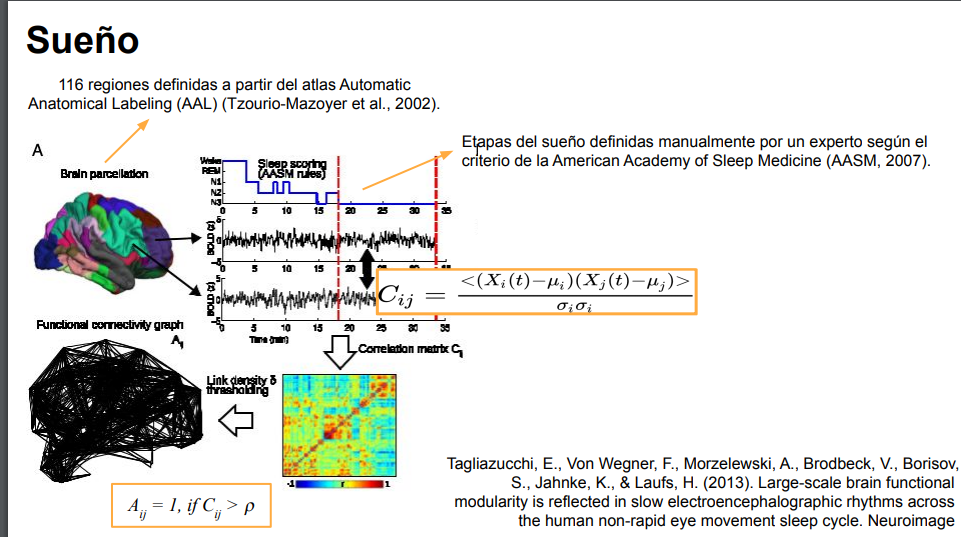

### Agrupamos por estadio de sueño

In [183]:
# Matriz general
sujetos_df.loc[sujetos_df['estadio'] == 'N1', sujetos_df.columns[0:116]]
ALL = sujetos_df.groupby(sujetos_df.index).mean()
ALL.shape

(116, 116)

In [184]:
# Matriz para N1
N1 = sujetos_df.loc[sujetos_df['estadio'] == 'N1', sujetos_df.columns[0:116]]
N1 = N1.groupby(N1.index).mean()
N1.shape

(116, 116)

In [185]:
# Matriz para N2
N2 = sujetos_df.loc[sujetos_df['estadio'] == 'N2', sujetos_df.columns[0:116]]
N2 = N2.groupby(N2.index).mean()
N2.shape

(116, 116)

In [186]:
# Matriz para N3
N3 = sujetos_df.loc[sujetos_df['estadio'] == 'N3', sujetos_df.columns[0:116]]
N3 = N3.groupby(N3.index).mean()
N3.shape

(116, 116)

In [187]:
# Matriz para W
W = sujetos_df.loc[sujetos_df['estadio'] == 'W', sujetos_df.columns[0:116]]
W = W.groupby(W.index).mean()
W.shape

(116, 116)

### Visualizar distribucion de pesos

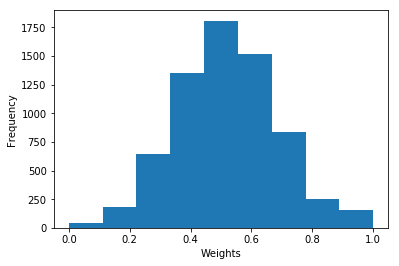

In [188]:
G_N1 = nx.from_numpy_matrix(N1.values)
plt.figure()
weights = [att['weight'] for n1, n2, att  in G_N1.edges(data=True)]
plt.hist(weights,bins=np.linspace(0,1,10));
plt.ylabel('Frequency')
plt.xlabel('Weights');

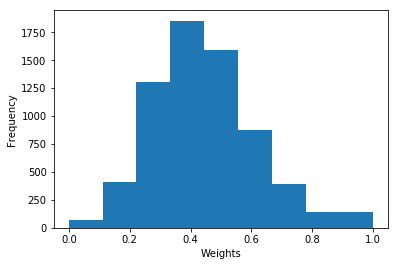

In [189]:
G_N2 = nx.from_numpy_matrix(N2.values)
plt.figure()
weights = [att['weight'] for n1, n2, att  in G_N2.edges(data=True)]
plt.hist(weights,bins=np.linspace(0,1,10));
plt.ylabel('Frequency')
plt.xlabel('Weights');

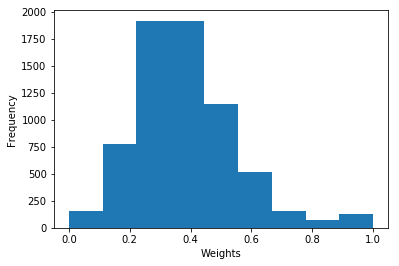

In [190]:
G_N3 = nx.from_numpy_matrix(N3.values)
plt.figure()
weights = [att['weight'] for n1, n2, att  in G_N3.edges(data=True)]
plt.hist(weights,bins=np.linspace(0,1,10));
plt.ylabel('Frequency')
plt.xlabel('Weights');

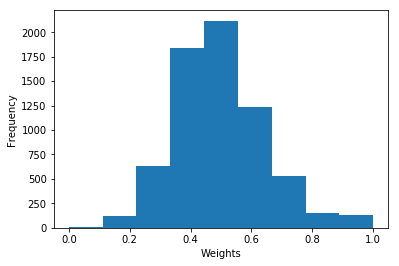

In [191]:
G_W = nx.from_numpy_matrix(W.values)
plt.figure()
weights = [att['weight'] for n1, n2, att  in G_W.edges(data=True)]
plt.hist(weights,bins=np.linspace(0,1,10));
plt.ylabel('Frequency')
plt.xlabel('Weights');

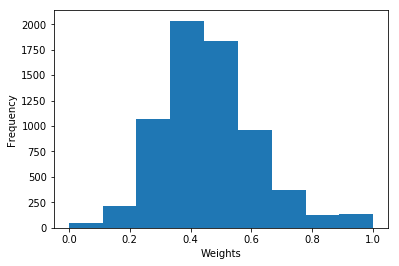

In [192]:
G_ALL = nx.from_numpy_matrix(ALL.values)
plt.figure()
weights = [att['weight'] for n1, n2, att  in G_ALL.edges(data=True)]
plt.hist(weights,bins=np.linspace(0,1,10));
plt.ylabel('Frequency')
plt.xlabel('Weights');

Text(0.5, 1.0, 'W')

<Figure size 432x288 with 0 Axes>

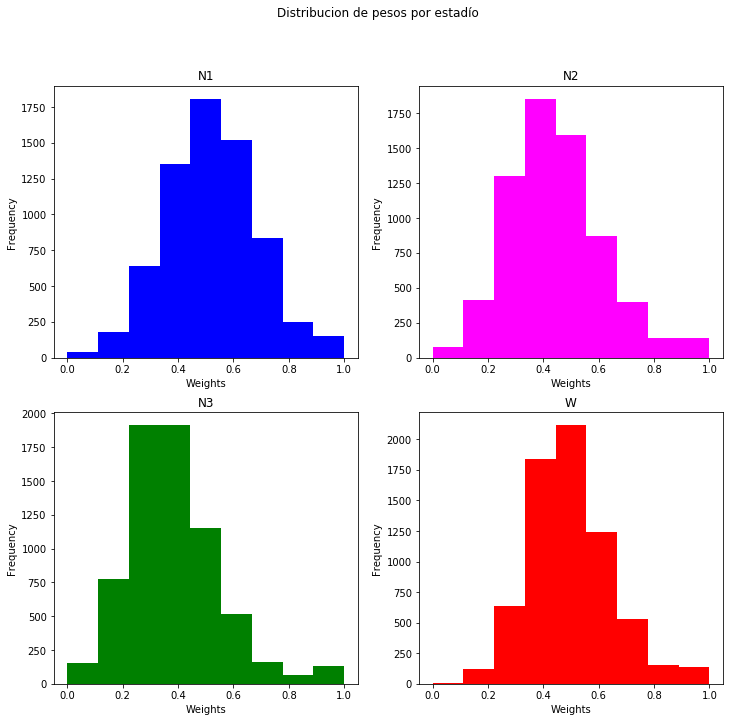

In [193]:

plt.tight_layout()
plt.figure(figsize=(12,11))
plt.suptitle('Distribucion de pesos por estadío')

plt.subplot(221)
weights = [att['weight'] for n1, n2, att  in G_N1.edges(data=True)]
plt.hist(weights,bins=np.linspace(0,1,10), color= 'blue');
plt.ylabel('Frequency')
plt.xlabel('Weights')
plt.title('N1')
plt.subplot(222)
weights = [att['weight'] for n1, n2, att  in G_N2.edges(data=True)]
plt.hist(weights,bins=np.linspace(0,1,10), color = "magenta");
plt.ylabel('Frequency')
plt.xlabel('Weights')
plt.title('N2')
plt.subplot(223)
weights = [att['weight'] for n1, n2, att  in G_N3.edges(data=True)]
plt.hist(weights,bins=np.linspace(0,1,10), color = 'green');
plt.ylabel('Frequency')
plt.xlabel('Weights')
plt.title('N3')
plt.subplot(224)
weights = [att['weight'] for n1, n2, att  in G_W.edges(data=True)]
plt.hist(weights,bins=np.linspace(0,1,10), color = 'red');
plt.ylabel('Frequency')
plt.xlabel('Weights')
plt.title('W')

### Convertir grafos ponderados a grafos binarios

Evaluar si es mejor establecer un solo humbral para todos los estadios de sueño o hacerlo por separado.

In [194]:
densidades = np.linspace(0.0001,0.990,25)

In [195]:
def tmatrix2graphsdict(correlation_matrix, densities):
    """
    Toma un dataframe de correlacion y lo filtra por las desidades.
    Quedandose con el porcentaje de correspondiente de aristas. 
    Devolviendo un diccionario de grafos por threshold
    """
    n = correlation_matrix.shape[0]
    max_links = (n*n-n)//2
    tril_idx = np.tril_indices(n,-1)
    sorted_correlations = sorted(correlation_matrix.values[tril_idx].flatten(),reverse=True)
    
    Gs = {}
    for d in densities:
        idx = int((d*max_links) -1)
        threshold = sorted_correlations[idx]
        Gs[str(d)] = nx.from_pandas_adjacency(correlation_matrix>=threshold)
        
    return Gs

In [196]:
aristas = {}
centralidad_grado = {}
centralidad_cercania = {}
centralidad_camino_min = {}
grado = {}

"\nplt.figure(figsize=(18, 10))\nplt.subplot(231)\nplt.plot(list(centralidad_cercania['ALL'].keys()), list(centralidad_cercania['ALL'].values()))\nplt.title('Centralidad por cercania')\nplt.subplot(232)\nplt.plot(list(centralidad_camino_min['ALL'].keys()), list(centralidad_camino_min['ALL'].values()))\nplt.title('Centralidad camino minimo')\nplt.subplot(233)\nplt.plot(list(grado['ALL'].keys()), list(grado['ALL'].values()))\nplt.title('Coeficiente de Clustering')\nplt.subplot(234)\nplt.plot(list(centralidad_grado['ALL'].keys()), list(centralidad_grado['ALL'].values()))\nplt.title('Centralidad de grado')\nplt.show()\n"

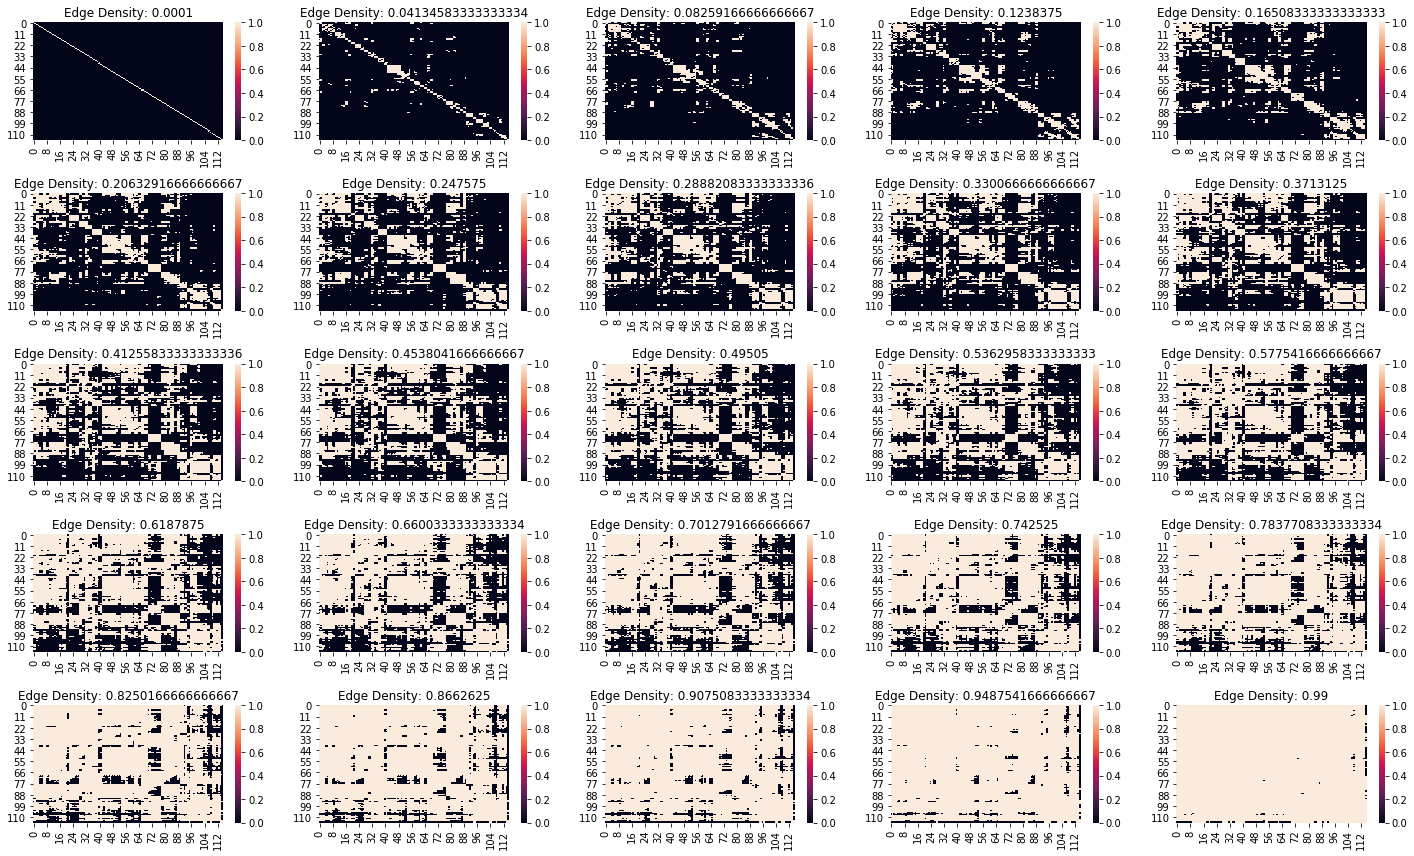

In [197]:
# ALL
graph_dict = tmatrix2graphsdict(ALL, densidades)
plt.figure(figsize=(20,12))

i = 0

aristas['ALL'] = {}
centralidad_grado['ALL'] = {}
centralidad_cercania['ALL'] = {}
centralidad_camino_min['ALL'] = {}
grado['ALL'] = {}

for key in graph_dict:
    G = graph_dict[key]
    plt.subplot(5,5,i+1)
    i = i + 1
    sns.heatmap(nx.to_numpy_array(G))
    plt.title('Edge Density: {}'.format(key))
    ind_cent = nx.degree_centrality(G).values()
    ind_closs = nx.closeness_centrality(G).values()
    ind_betw = nx.betweenness_centrality(G).values()
    aristas['ALL'][float(key)] = G.number_of_edges()
    centralidad_grado['ALL'][float(key)] = sum(ind_cent)/len(ind_cent)
    centralidad_cercania['ALL'][float(key)] = sum(ind_closs)/len(ind_closs)
    centralidad_camino_min['ALL'][float(key)] = sum(ind_betw)/len(ind_betw)
    grado['ALL'][float(key)] = nx.average_clustering(G)
plt.tight_layout()


'''
plt.figure(figsize=(18, 10))
plt.subplot(231)
plt.plot(list(centralidad_cercania['ALL'].keys()), list(centralidad_cercania['ALL'].values()))
plt.title('Centralidad por cercania')
plt.subplot(232)
plt.plot(list(centralidad_camino_min['ALL'].keys()), list(centralidad_camino_min['ALL'].values()))
plt.title('Centralidad camino minimo')
plt.subplot(233)
plt.plot(list(grado['ALL'].keys()), list(grado['ALL'].values()))
plt.title('Coeficiente de Clustering')
plt.subplot(234)
plt.plot(list(centralidad_grado['ALL'].keys()), list(centralidad_grado['ALL'].values()))
plt.title('Centralidad de grado')
plt.show()
'''

"\nplt.figure(figsize=(18, 10))\nplt.subplot(231)\nplt.plot(list(centralidad_cercania['W'].keys()), list(centralidad_cercania['W'].values()))\nplt.title('Centralidad por cercania')\nplt.subplot(232)\nplt.plot(list(centralidad_camino_min['W'].keys()), list(centralidad_camino_min['W'].values()))\nplt.title('Centralidad camino minimo')\nplt.subplot(233)\nplt.plot(list(grado['W'].keys()), list(grado['W'].values()))\nplt.title('Coeficiente de Clustering')\nplt.subplot(234)\nplt.plot(list(centralidad_grado['W'].keys()), list(centralidad_grado['W'].values()))\nplt.title('Centralidad de grado')\nplt.show()\n"

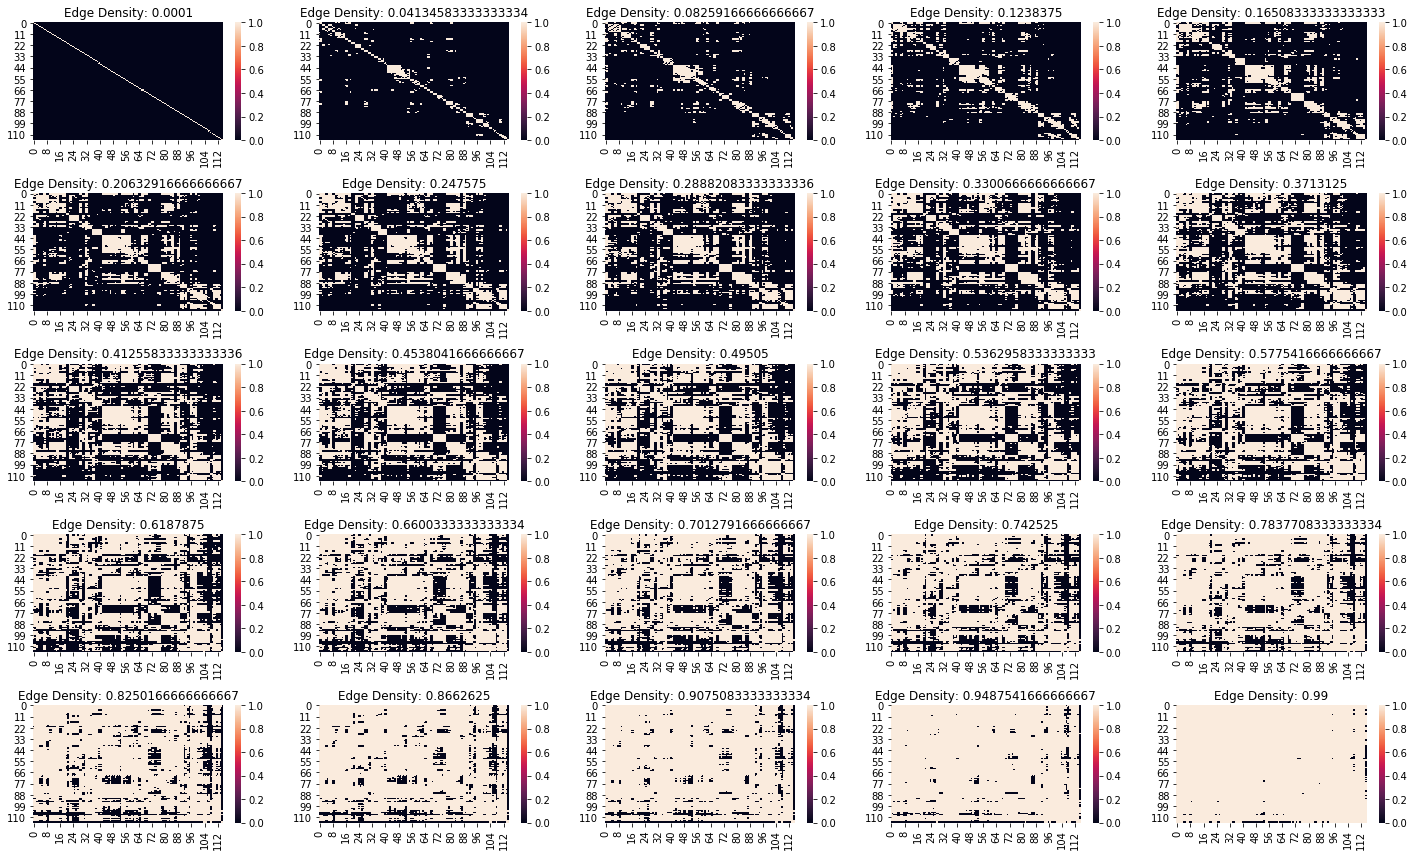

In [198]:
# W
graph_dict = tmatrix2graphsdict(W, densidades)
plt.figure(figsize=(20,12))
i = 0

aristas['W'] = {}
centralidad_grado['W'] = {}
centralidad_cercania['W']= {}
centralidad_camino_min['W'] = {}
grado['W'] = {}

for key in graph_dict:
    G = graph_dict[key]
    plt.subplot(5,5,i+1)
    i = i + 1
    sns.heatmap(nx.to_numpy_array(G))
    plt.title('Edge Density: {}'.format(key))
    ind_cent = nx.degree_centrality(G).values()
    ind_closs = nx.closeness_centrality(G).values()
    ind_betw = nx.betweenness_centrality(G).values()
    aristas['W'][float(key)] = G.number_of_edges()
    centralidad_grado['W'][float(key)] = sum(ind_cent)/len(ind_cent)
    centralidad_cercania['W'][float(key)] = sum(ind_closs)/len(ind_closs)
    centralidad_camino_min['W'][float(key)] = sum(ind_betw)/len(ind_betw)
    grado['W'][float(key)] = nx.average_clustering(G)
plt.tight_layout()
'''
plt.figure(figsize=(18, 10))
plt.subplot(231)
plt.plot(list(centralidad_cercania['W'].keys()), list(centralidad_cercania['W'].values()))
plt.title('Centralidad por cercania')
plt.subplot(232)
plt.plot(list(centralidad_camino_min['W'].keys()), list(centralidad_camino_min['W'].values()))
plt.title('Centralidad camino minimo')
plt.subplot(233)
plt.plot(list(grado['W'].keys()), list(grado['W'].values()))
plt.title('Coeficiente de Clustering')
plt.subplot(234)
plt.plot(list(centralidad_grado['W'].keys()), list(centralidad_grado['W'].values()))
plt.title('Centralidad de grado')
plt.show()
'''


"\nplt.figure(figsize=(18, 10))\nplt.subplot(231)\nplt.plot(list(centralidad_cercania['N1'].keys()), list(centralidad_cercania['N1'].values()))\nplt.title('Centralidad por cercania')\nplt.subplot(232)\nplt.plot(list(centralidad_camino_min['N1'].keys()), list(centralidad_camino_min['N1'].values()))\nplt.title('Centralidad camino minimo')\nplt.subplot(233)\nplt.plot(list(grado['N1'].keys()), list(grado['N1'].values()))\nplt.title('Coeficiente de Clustering')\nplt.subplot(234)\nplt.plot(list(centralidad_grado['N1'].keys()), list(centralidad_grado['N1'].values()))\nplt.title('Centralidad de grado')\nplt.show()\n"

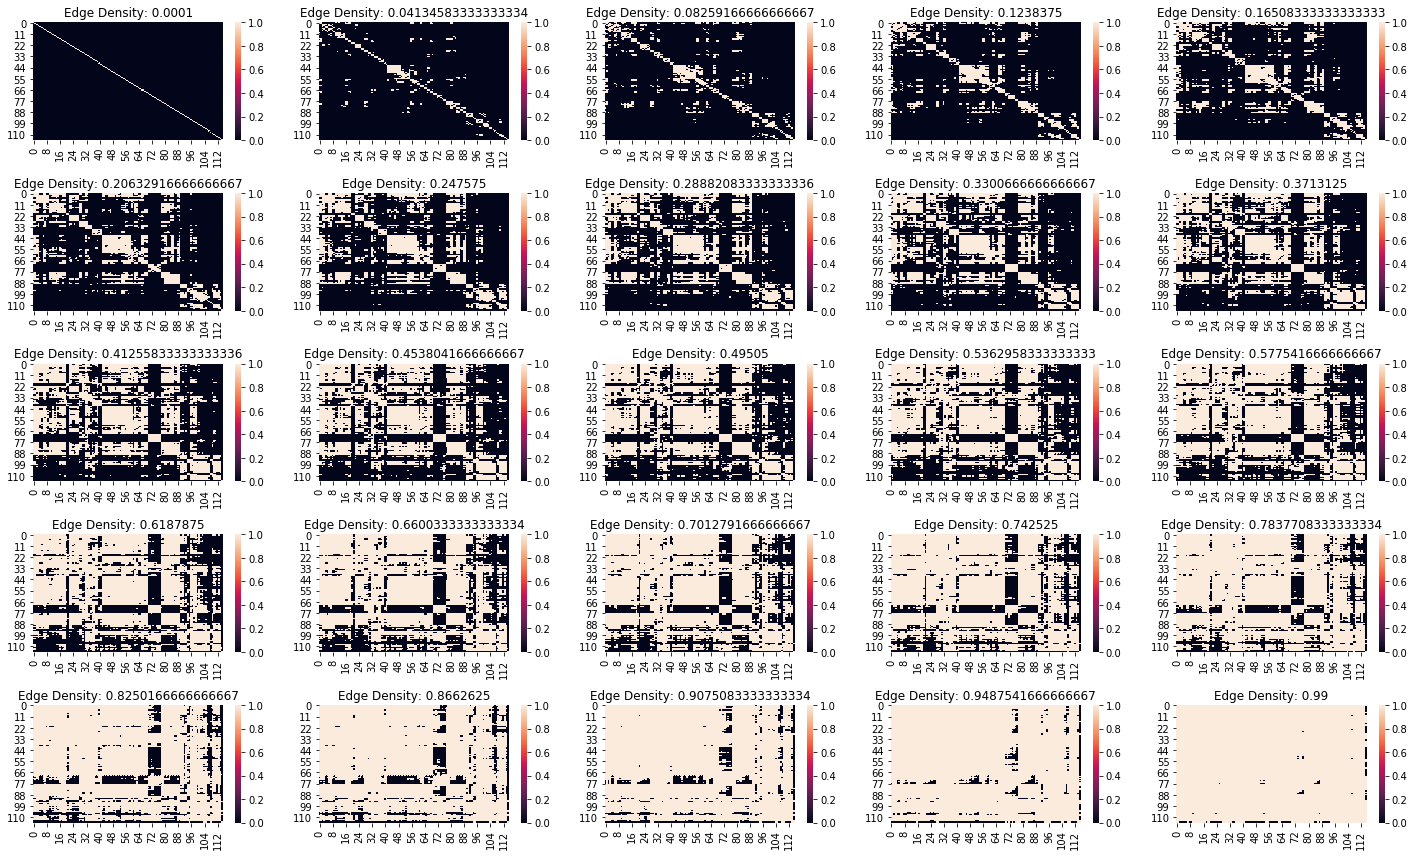

In [199]:
# N1
graph_dict = tmatrix2graphsdict(N1, densidades)
plt.figure(figsize=(20,12))
i = 0
aristas['N1'] = {}
centralidad_grado['N1'] = {}
centralidad_cercania['N1'] = {}
centralidad_camino_min['N1'] = {}
grado['N1'] = {}

for key in graph_dict:
    G = graph_dict[key]
    plt.subplot(5,5,i+1)
    i = i + 1
    sns.heatmap(nx.to_numpy_array(G))
    plt.title('Edge Density: {}'.format(key))
    ind_cent = nx.degree_centrality(G).values()
    ind_closs = nx.closeness_centrality(G).values()
    ind_betw = nx.betweenness_centrality(G).values()
    aristas['N1'][float(key)] = G.number_of_edges()
    centralidad_grado['N1'][float(key)] = sum(ind_cent)/len(ind_cent)
    centralidad_cercania['N1'][float(key)] = sum(ind_closs)/len(ind_closs)
    centralidad_camino_min['N1'][float(key)] = sum(ind_betw)/len(ind_betw)
    grado['N1'][float(key)] = nx.average_clustering(G)
plt.tight_layout()
'''
plt.figure(figsize=(18, 10))
plt.subplot(231)
plt.plot(list(centralidad_cercania['N1'].keys()), list(centralidad_cercania['N1'].values()))
plt.title('Centralidad por cercania')
plt.subplot(232)
plt.plot(list(centralidad_camino_min['N1'].keys()), list(centralidad_camino_min['N1'].values()))
plt.title('Centralidad camino minimo')
plt.subplot(233)
plt.plot(list(grado['N1'].keys()), list(grado['N1'].values()))
plt.title('Coeficiente de Clustering')
plt.subplot(234)
plt.plot(list(centralidad_grado['N1'].keys()), list(centralidad_grado['N1'].values()))
plt.title('Centralidad de grado')
plt.show()
'''

"\nplt.figure(figsize=(18, 10))\nplt.subplot(231)\nplt.plot(list(centralidad_cercania['N2'].keys()), list(centralidad_cercania['N2'].values()))\nplt.title('Centralidad por cercania')\nplt.subplot(232)\nplt.plot(list(centralidad_camino_min['N2'].keys()), list(centralidad_camino_min['N2'].values()))\nplt.title('Centralidad camino minimo')\nplt.subplot(233)\nplt.plot(list(grado['N2'].keys()), list(grado['N2'].values()))\nplt.title('Coeficiente de Clustering')\nplt.subplot(234)\nplt.plot(list(centralidad_grado['N2'].keys()), list(centralidad_grado['N2'].values()))\nplt.title('Centralidad de grado')\nplt.show()\n"

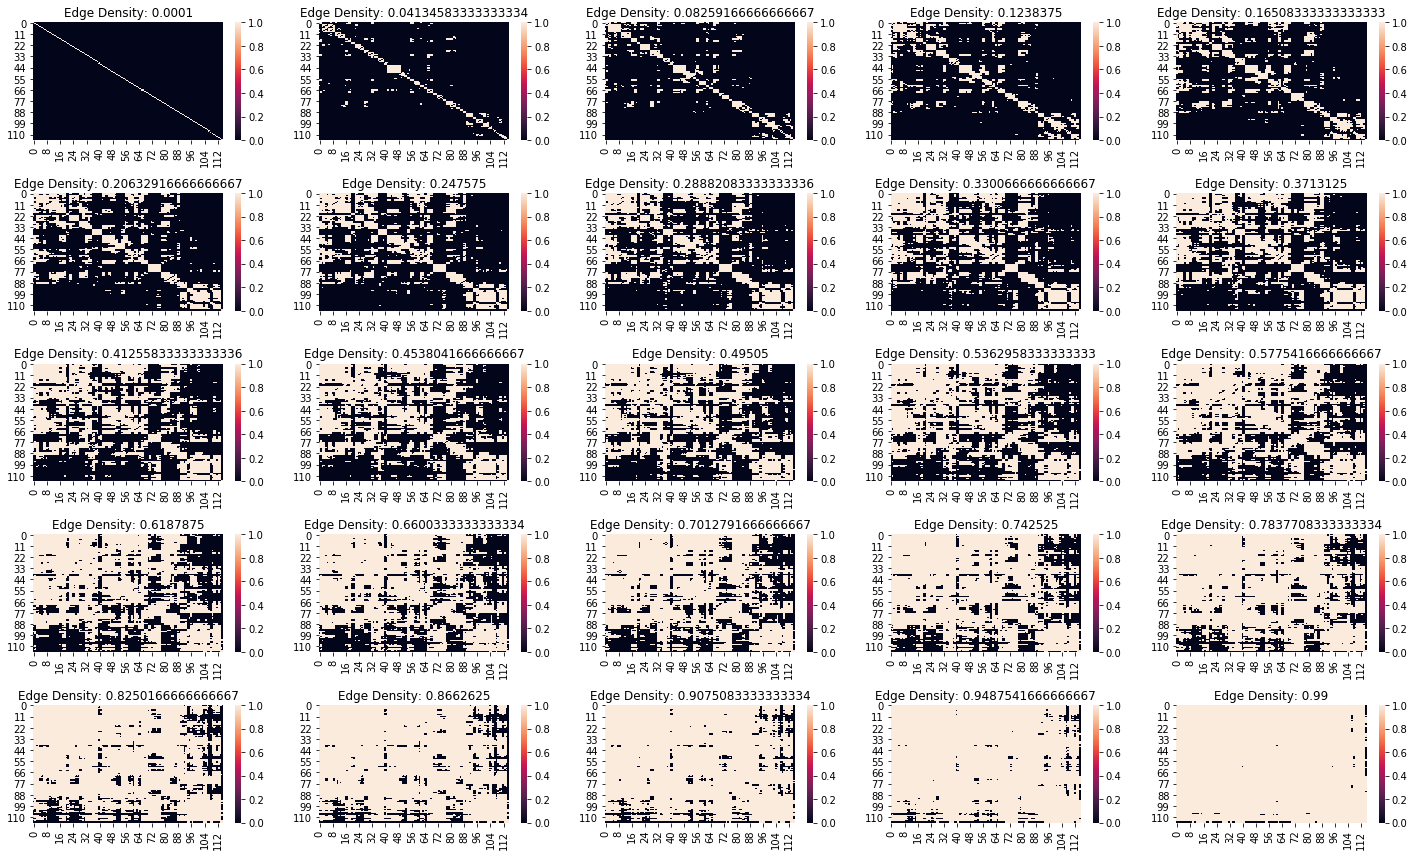

In [200]:
# N2
graph_dict = tmatrix2graphsdict(N2, densidades)
plt.figure(figsize=(20,12))
i = 0
aristas['N2'] = {}
centralidad_grado['N2'] = {}
centralidad_cercania['N2'] = {}
centralidad_camino_min['N2'] = {}
grado['N2'] = {}
for key in graph_dict:
    G = graph_dict[key]
    plt.subplot(5,5,i+1)
    i = i + 1
    sns.heatmap(nx.to_numpy_array(G))
    plt.title('Edge Density: {}'.format(key))
    ind_cent = nx.degree_centrality(G).values()
    ind_closs = nx.closeness_centrality(G).values()
    ind_betw = nx.betweenness_centrality(G).values()
    aristas['N2'][float(key)] = G.number_of_edges()
    centralidad_grado['N2'][float(key)] = sum(ind_cent)/len(ind_cent)
    centralidad_cercania['N2'][float(key)] = sum(ind_closs)/len(ind_closs)
    centralidad_camino_min['N2'][float(key)] = sum(ind_betw)/len(ind_betw)
    grado['N2'][float(key)] = nx.average_clustering(G)
plt.tight_layout()
'''
plt.figure(figsize=(18, 10))
plt.subplot(231)
plt.plot(list(centralidad_cercania['N2'].keys()), list(centralidad_cercania['N2'].values()))
plt.title('Centralidad por cercania')
plt.subplot(232)
plt.plot(list(centralidad_camino_min['N2'].keys()), list(centralidad_camino_min['N2'].values()))
plt.title('Centralidad camino minimo')
plt.subplot(233)
plt.plot(list(grado['N2'].keys()), list(grado['N2'].values()))
plt.title('Coeficiente de Clustering')
plt.subplot(234)
plt.plot(list(centralidad_grado['N2'].keys()), list(centralidad_grado['N2'].values()))
plt.title('Centralidad de grado')
plt.show()
'''

"\nplt.figure(figsize=(18, 10))\nplt.subplot(231)\nplt.plot(list(centralidad_cercania['N3'].keys()), list(centralidad_cercania['N3'].values()))\nplt.title('Centralidad por cercania')\nplt.subplot(232)\nplt.plot(list(centralidad_camino_min['N3'].keys()), list(centralidad_camino_min['N3'].values()))\nplt.title('Centralidad camino minimo')\nplt.subplot(233)\nplt.plot(list(grado['N3'].keys()), list(grado['N3'].values()))\nplt.title('Coeficiente de Clustering')\nplt.subplot(234)\nplt.plot(list(centralidad_grado['N3'].keys()), list(centralidad_grado['N3'].values()))\nplt.title('Centralidad de grado')\nplt.show()\n"

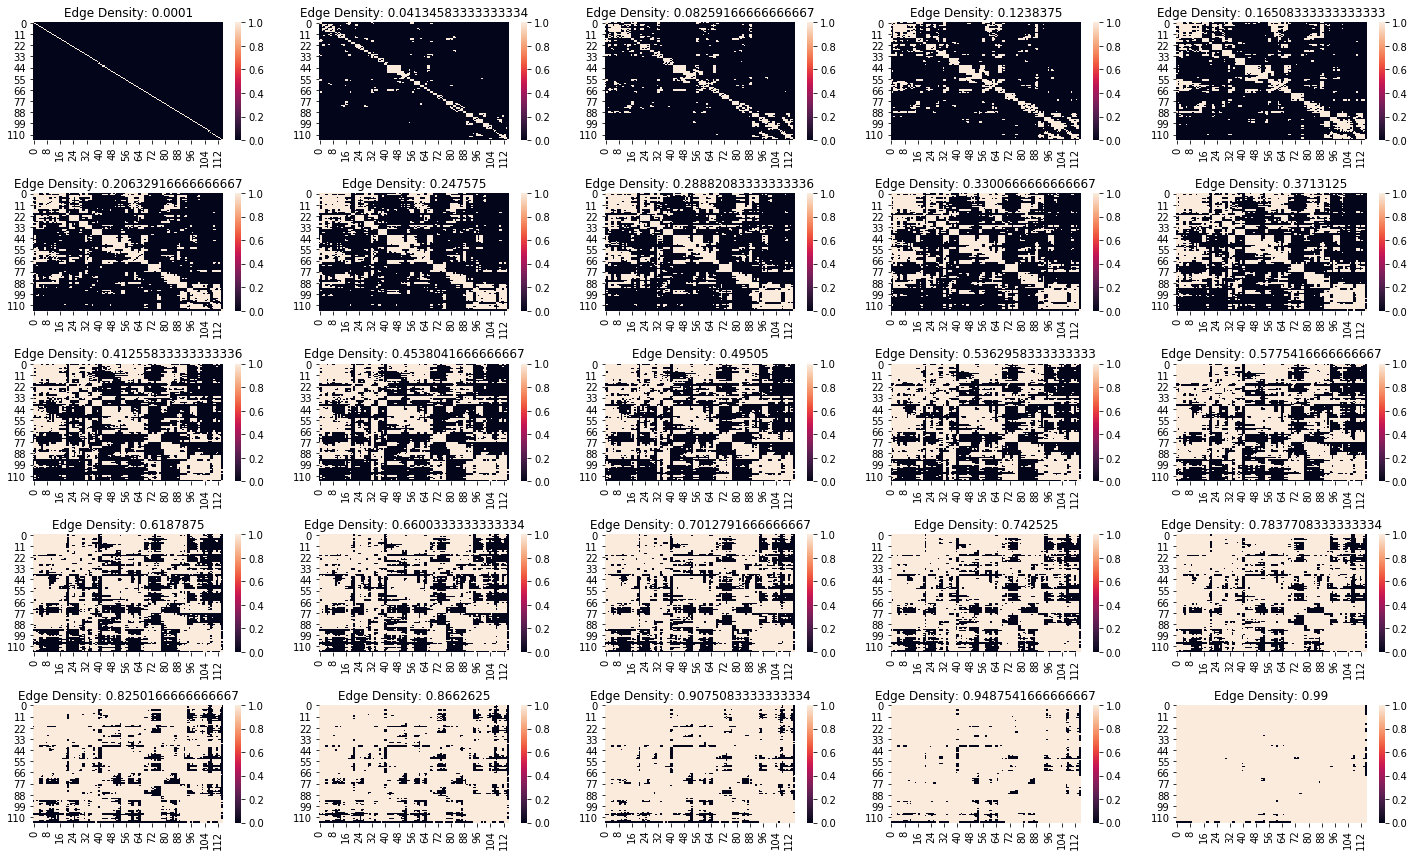

In [201]:
# N3
graph_dict = tmatrix2graphsdict(N3, densidades)
plt.figure(figsize=(20,12))
i = 0
aristas['N3'] = {}
centralidad_grado['N3'] = {}
centralidad_cercania['N3'] = {}
centralidad_camino_min['N3'] = {}
grado['N3'] = {}

for key in graph_dict:
    G = graph_dict[key]
    plt.subplot(5,5,i+1)
    i = i + 1
    sns.heatmap(nx.to_numpy_array(G))
    plt.title('Edge Density: {}'.format(key))
    ind_cent = nx.degree_centrality(G).values()
    ind_closs = nx.closeness_centrality(G).values()
    ind_betw = nx.betweenness_centrality(G).values()
    aristas['N3'][float(key)] = G.number_of_edges()
    centralidad_grado['N3'][float(key)] = sum(ind_cent)/len(ind_cent)
    centralidad_cercania['N3'][float(key)] = sum(ind_closs)/len(ind_closs)
    centralidad_camino_min['N3'][float(key)] = sum(ind_betw)/len(ind_betw)
    grado['N3'][float(key)] = nx.average_clustering(G)
plt.tight_layout()
'''
plt.figure(figsize=(18, 10))
plt.subplot(231)
plt.plot(list(centralidad_cercania['N3'].keys()), list(centralidad_cercania['N3'].values()))
plt.title('Centralidad por cercania')
plt.subplot(232)
plt.plot(list(centralidad_camino_min['N3'].keys()), list(centralidad_camino_min['N3'].values()))
plt.title('Centralidad camino minimo')
plt.subplot(233)
plt.plot(list(grado['N3'].keys()), list(grado['N3'].values()))
plt.title('Coeficiente de Clustering')
plt.subplot(234)
plt.plot(list(centralidad_grado['N3'].keys()), list(centralidad_grado['N3'].values()))
plt.title('Centralidad de grado')
plt.show()
'''

## 3. Tarea 1: Visualización
### Sobre los datos promedio, extraer medidas de centralidad, grado, camino mínimo, y coeficiente de clustering en función de la densidad de aristas en función de la densidad.

<Figure size 432x288 with 0 Axes>

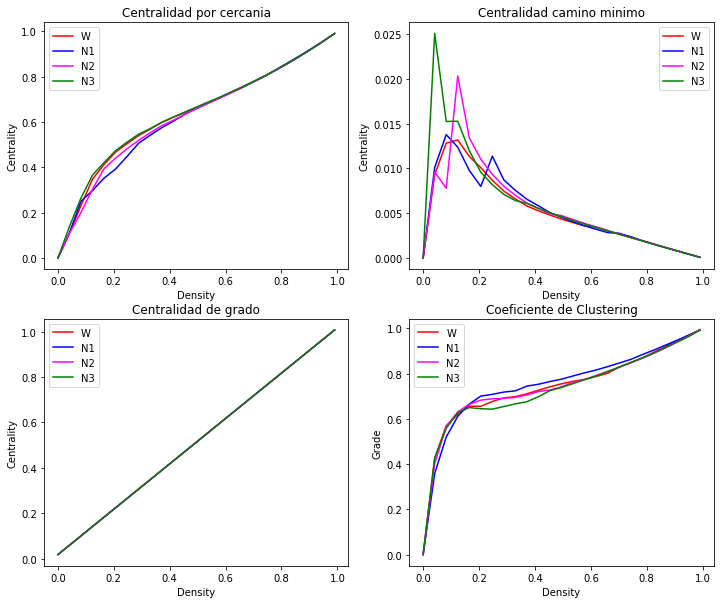

In [202]:
plt.tight_layout()

plt.figure(figsize=(12, 10))


plt.subplot(221)
plt.plot(list(centralidad_cercania['W'].keys()), list(centralidad_cercania['W'].values()), label='W', color = 'red')
plt.plot(list(centralidad_cercania['N1'].keys()), list(centralidad_cercania['N1'].values()), label='N1', color = 'blue')
plt.plot(list(centralidad_cercania['N2'].keys()), list(centralidad_cercania['N2'].values()), label='N2', color = 'magenta')
plt.plot(list(centralidad_cercania['N3'].keys()), list(centralidad_cercania['N3'].values()), label='N3', color = 'green')
plt.legend()
plt.ylabel('Centrality')
plt.xlabel('Density')
plt.title('Centralidad por cercania')

plt.subplot(222)
plt.plot(list(centralidad_camino_min['W'].keys()), list(centralidad_camino_min['W'].values()), label='W', color = 'red')
plt.plot(list(centralidad_camino_min['N1'].keys()), list(centralidad_camino_min['N1'].values()), label='N1', color = 'blue')
plt.plot(list(centralidad_camino_min['N2'].keys()), list(centralidad_camino_min['N2'].values()), label='N2', color = 'magenta')
plt.plot(list(centralidad_camino_min['N3'].keys()), list(centralidad_camino_min['N3'].values()), label='N3', color = 'green')
plt.legend()
plt.ylabel('Centrality')
plt.xlabel('Density')
plt.title('Centralidad camino minimo')

plt.subplot(223)
plt.plot(list(centralidad_grado['W'].keys()), list(centralidad_grado['W'].values()), label='W', color = 'red')
plt.plot(list(centralidad_grado['N1'].keys()), list(centralidad_grado['N1'].values()), label='N1', color = 'blue')
plt.plot(list(centralidad_grado['N2'].keys()), list(centralidad_grado['N2'].values()), label='N2', color = 'magenta')
plt.plot(list(centralidad_grado['N3'].keys()), list(centralidad_grado['N3'].values()), label='N3', color = 'green')
plt.legend()
plt.ylabel('Centrality')
plt.xlabel('Density')
plt.title('Centralidad de grado')

plt.subplot(224)
plt.plot(list(grado['W'].keys()), list(grado['W'].values()), label='W', color = 'red')
plt.plot(list(grado['N1'].keys()), list(grado['N1'].values()), label='N1', color = 'blue')
plt.plot(list(grado['N2'].keys()), list(grado['N2'].values()), label='N2', color = 'magenta')
plt.plot(list(grado['N3'].keys()), list(grado['N3'].values()), label='N3', color = 'green')
plt.legend()
plt.ylabel('Grade')
plt.xlabel('Density')
plt.title('Coeficiente de Clustering')


plt.show()



### Visualizar el grafo no pesado para distintos valores de δ que resulten interesantes.

In [203]:
#reduzco los valores posibles de densidad para que sean mas legibles los graficos
den_array = [0.05, 0.2, 0.4, 0.8]
graph_dict_W = tmatrix2graphsdict(W, den_array)
graph_dict_N1 = tmatrix2graphsdict(N1, den_array)
graph_dict_N2 = tmatrix2graphsdict(N2, den_array)
graph_dict_N3 = tmatrix2graphsdict(N3, den_array)
graph_dict_ALL = tmatrix2graphsdict(ALL, den_array)

C:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibD

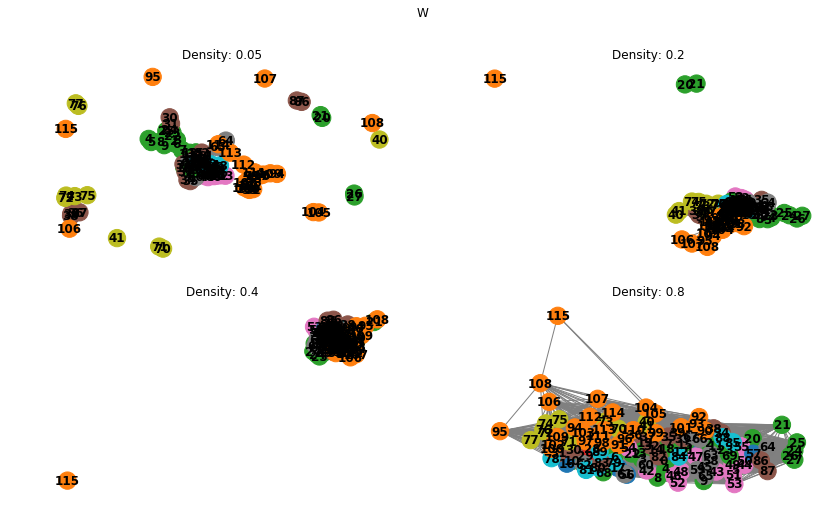

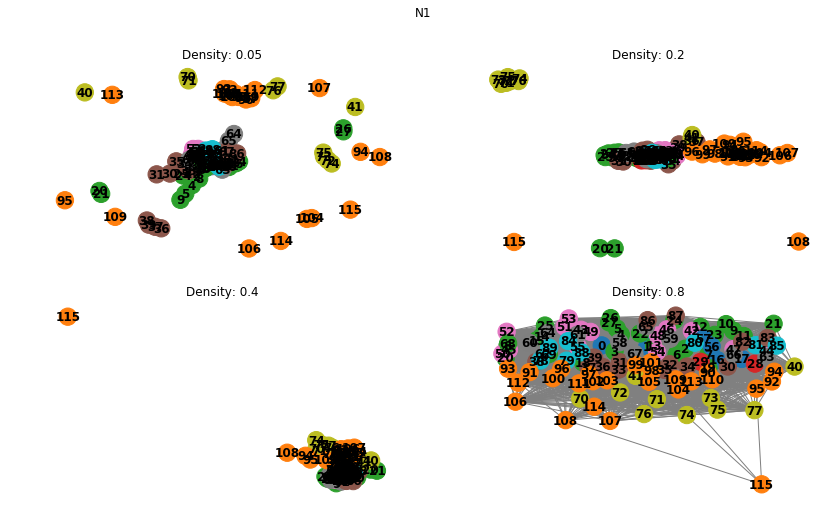

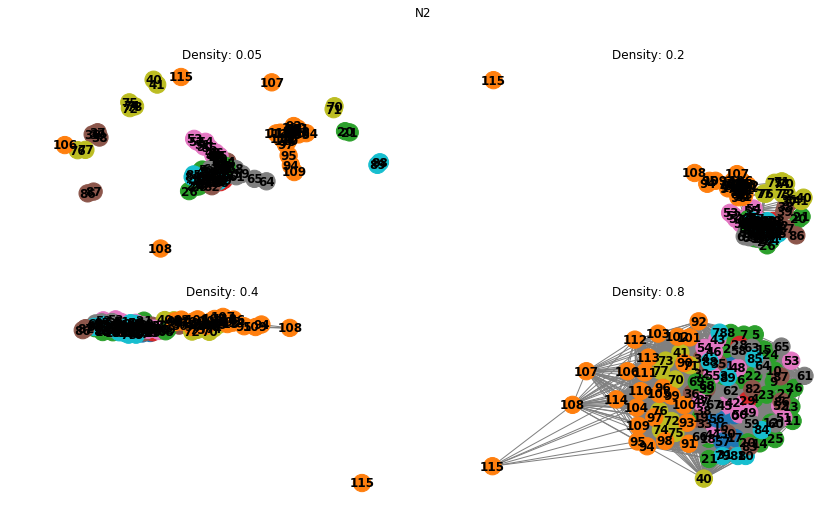

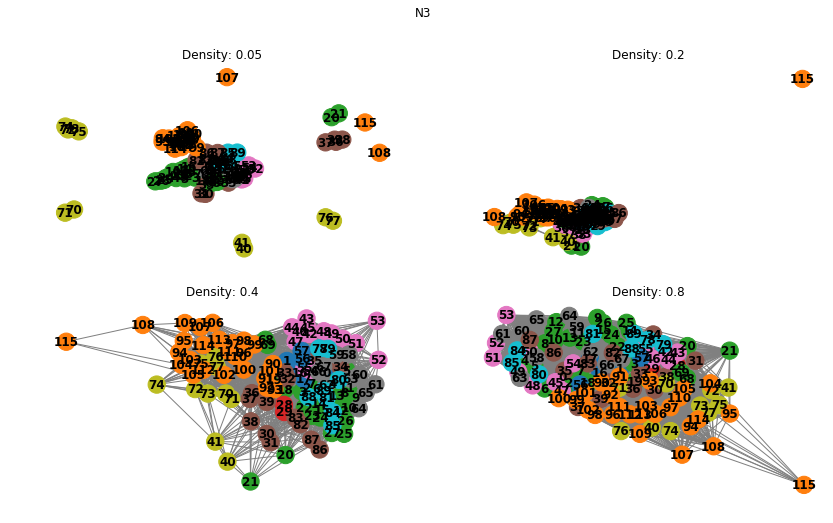

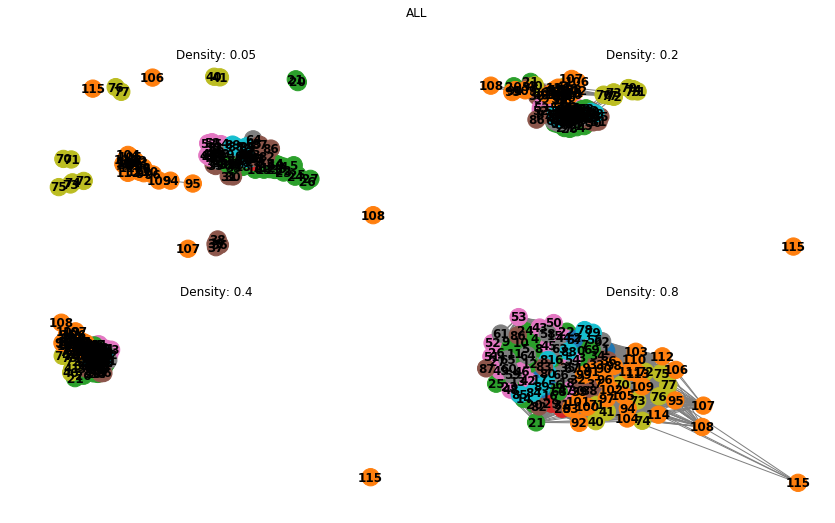

In [204]:
d = dict([(y,x+1) for x,y in enumerate(sorted(set(list(catalog.location))))])
color_map =[d[x] for x in list(catalog.location)]
i = 0
plt.figure(figsize=(14,8))
plt.suptitle('W')

for den in graph_dict_W.keys():
    i= i + 1
    plt.subplot(2,2,i)
    plt.title('Density: ' + str(den))
    nx.draw(graph_dict_W[den], with_labels=True,cmap=plt.cm.tab10,font_weight='bold',node_color = color_map, font_color='black', edge_color='gray')
    
i = 0
plt.figure(figsize=(14,8))
plt.suptitle('N1')
for den in graph_dict_N1.keys():
    i= i + 1
    plt.subplot(2,2,i)
    plt.title('Density: ' + str(den))
    nx.draw(graph_dict_N1[den], with_labels=True,cmap=plt.cm.tab10,font_weight='bold',node_color = color_map, font_color='black', edge_color='gray')
    
i = 0
plt.figure(figsize=(14,8))
plt.suptitle('N2')
for den in graph_dict_N2.keys():
    i= i + 1
    plt.subplot(2,2,i)
    plt.title('Density: ' + str(den))
    nx.draw(graph_dict_N2[den], with_labels=True,cmap=plt.cm.tab10,font_weight='bold',node_color = color_map, font_color='black', edge_color='gray')

        
i = 0
plt.figure(figsize=(14,8))
plt.suptitle('N3')
for den in graph_dict_N3.keys():
    i= i + 1
    plt.subplot(2,2,i)
    plt.title('Density: ' + str(den))
    nx.draw(graph_dict_N3[den], with_labels=True,cmap=plt.cm.tab10,font_weight='bold',node_color = color_map, font_color='black', edge_color='gray')
    
i = 0
plt.figure(figsize=(14,8))
plt.suptitle('ALL')
for den in graph_dict_ALL.keys():
    i= i + 1
    plt.subplot(2,2,i)
    plt.title('Density: ' + str(den))

    nx.draw(graph_dict_ALL[den], with_labels=True,cmap=plt.cm.tab10,font_weight='bold',node_color = color_map, font_color='black', edge_color='gray')

C:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


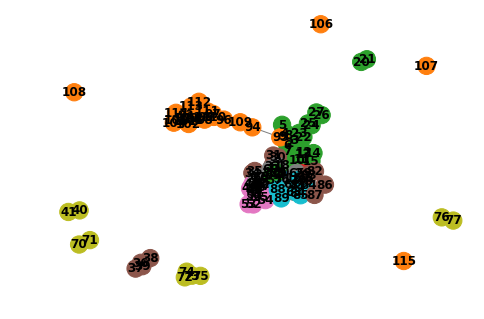

In [205]:
nx.draw(graph_dict_ALL['0.05'], with_labels=True,cmap=plt.cm.tab10,font_weight='bold',
        node_color = color_map, font_color='black', edge_color='gray')

C:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


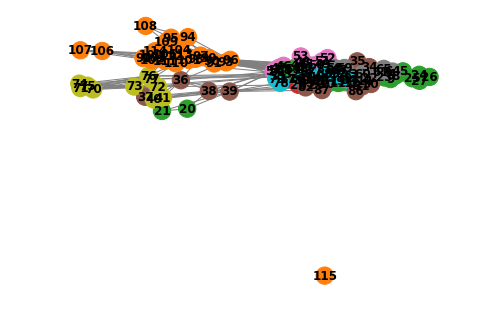

In [208]:
nx.draw(graph_dict_ALL['0.2'], with_labels=True,cmap=plt.cm.tab10,
        font_weight='bold',node_color = color_map, font_color='black', edge_color='gray')

C:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


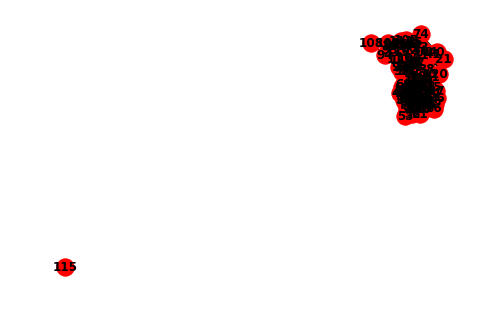

In [209]:
nx.draw(graph_dict_ALL['0.4'], with_labels=True, font_weight='bold')

C:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


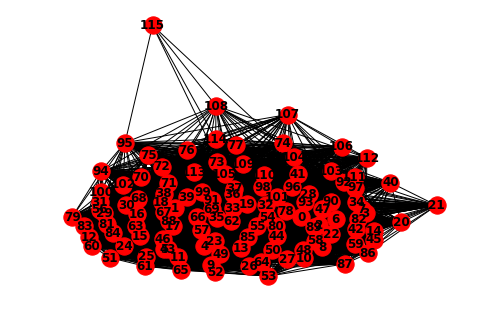

In [210]:
nx.draw(graph_dict_ALL['0.8'], with_labels=True, font_weight='bold')

## 4. Tarea 2: Comunidades y coeficiente de modularidad
Para los distintos valores de la densidad de aristas (δ), determinar comunidades a partir
de algoritmo de Louvain [Blondel et al., 2008] y estimar el coeficiente de modularidad (Q).
Graficar Q y el número de comunidades (NC) en función de δ, y comparar los resultados con
el comportamiento de una red random que preserve la distribución de grados de los nodos.

In [211]:
def print_comunidades(G_array, den_array):
    comunidades = {}
    comunidades_random = []
    modularidad = {}
    modularidad_random = []
    for d in den_array:
        G = G_array[str(d)]
        G_random = nx.gnm_random_graph(G.number_of_nodes(),G.number_of_edges()) 
        partition = community.best_partition(G)
        modularity = community.modularity(partition, G)
        partition_rand = community.best_partition(G_random)
        modularity_rand = community.modularity(partition_rand, G_random)
        comunidades[d] = len(set(partition.values()))
        comunidades_random.append(len(set(partition_rand.values())))
        modularidad[d] = modularity
        modularidad_random.append(modularity_rand)
        
    plt.tight_layout()
    plt.figure(figsize=(20, 10))
    plt.subplot(231)
    plt.plot(list(comunidades.keys()), list(comunidades.values()), label = 'Original Network')
    plt.plot(list(comunidades.keys()), comunidades_random, color='red', label = 'Random Network')
    plt.title('Cantidad de comunidades')
    plt.xlabel('Density')
    plt.ylabel('Nc')
    plt.legend()
    plt.subplot(232)
    plt.plot(list(modularidad.keys()), list(modularidad.values()), label = 'Original Network')
    plt.plot(list(modularidad.keys()), modularidad_random, color='red', label = 'Random Network')
    plt.title('Modularidad')
    plt.xlabel('Density')
    plt.ylabel('Q')
    plt.legend()


In [212]:
den_array = np.linspace(0.01,0.9,40)
graph_dict_all = tmatrix2graphsdict(ALL, den_array)
graph_dict_W = tmatrix2graphsdict(W, den_array)
graph_dict_N1 = tmatrix2graphsdict(N1, den_array)
graph_dict_N2 = tmatrix2graphsdict(N2, den_array)
graph_dict_N3 = tmatrix2graphsdict(N3, den_array)

<Figure size 432x288 with 0 Axes>

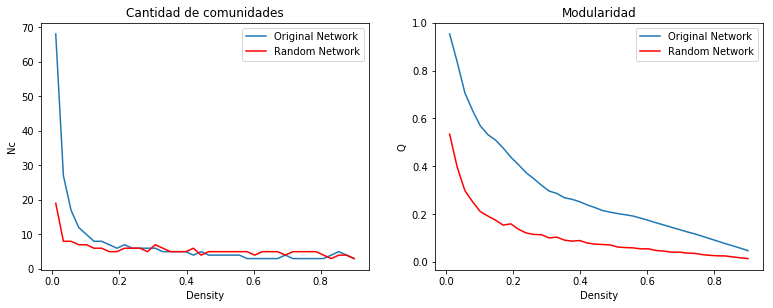

In [213]:
print_comunidades(graph_dict_all, den_array)

<Figure size 432x288 with 0 Axes>

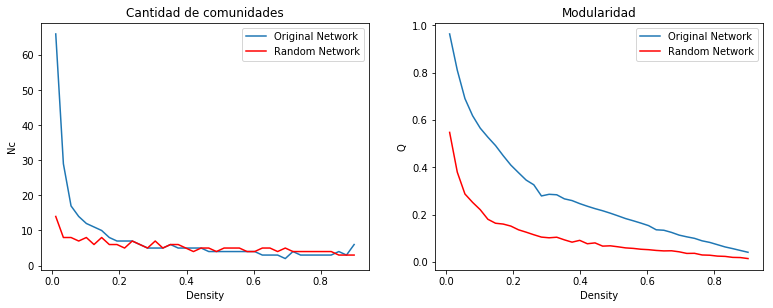

In [214]:
print_comunidades(graph_dict_W, den_array)

<Figure size 432x288 with 0 Axes>

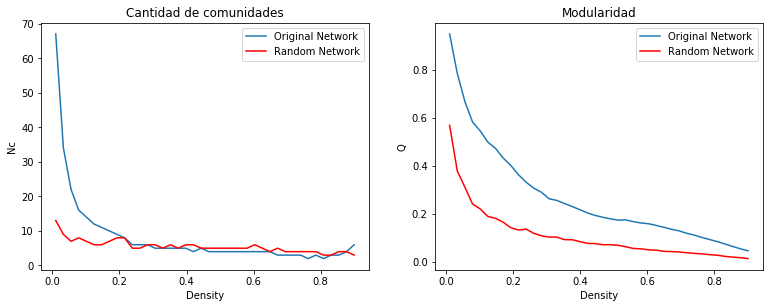

In [215]:
print_comunidades(graph_dict_N1, den_array)

<Figure size 432x288 with 0 Axes>

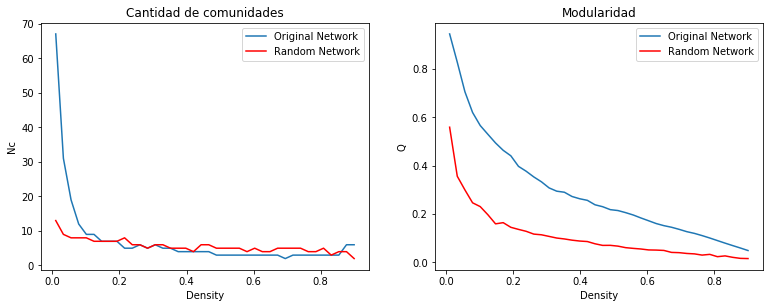

In [216]:
print_comunidades(graph_dict_N2, den_array)

<Figure size 432x288 with 0 Axes>

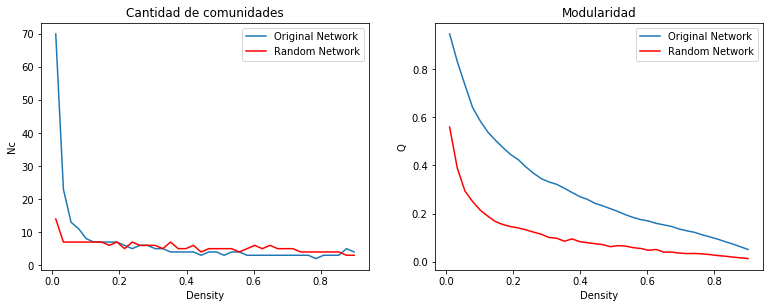

In [217]:
print_comunidades(graph_dict_N3, den_array)

### 5. Tarea 3: Estadística
Repetir las curvas de modularidad (Q) y número de comunidades (NC) para cada sujeto
y estadio del sueño, en función de δ, y comparar cada estadio N1, N2 y N3, con el estadio
despierto W. Para cada valor de δ incluir una noción de significancia entre estadíos del sueño.

In [218]:
den_array = np.linspace(0.01,0.4,40)
graph_dict_all = tmatrix2graphsdict(ALL, den_array)
graph_dict_W = tmatrix2graphsdict(W, den_array)
graph_dict_N1 = tmatrix2graphsdict(N1, den_array)
graph_dict_N2 = tmatrix2graphsdict(N2, den_array)
graph_dict_N3 = tmatrix2graphsdict(N3, den_array)

<Figure size 432x288 with 0 Axes>

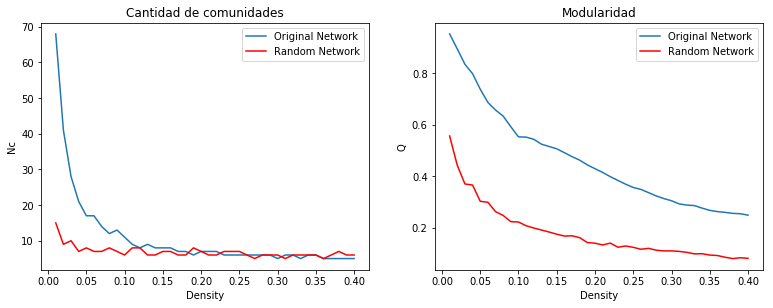

In [219]:
print_comunidades(graph_dict_all, den_array)

## 5. Tarea 3: Estadística - V2
Repetir las curvas de modularidad (Q) y número de comunidades (NC) para cada sujeto
y estadio del sueño, en función de δ, y comparar cada estadio N1, N2 y N3, con el estadio
despierto W. Para cada valor de δ incluir una noción de significancia entre estadíos del sueño.

In [220]:
def calc_comunidad_modularidad(G_array):
    """
    Toma un diccionario de grafos por densidades y 
    devuelve un dataframe con densidad, cantidad de comunidades y
    la modularidad.
    """
    df_comunidad_modularidad = pd.DataFrame(columns=['densidad', 'comunidades', 'modularidad'])
    comunidades = {}
    modularidad = {}
    for d in G_array.keys():
        G = G_array[str(d)]
        partition = community.best_partition(G)
        modularity = community.modularity(partition, G)
        df_comunidad_modularidad = df_comunidad_modularidad.append({'densidad': d, 
             'comunidades': len(set(partition.values())), 'modularidad': modularity}, ignore_index=True)

    return df_comunidad_modularidad



In [221]:
#armo dataframe con las comunidades y modularidad de cada sujeto para cada estadio

den_array = np.linspace(0.01,0.9,40)

df_comunidades_modularidad_sujeto_estado = pd.DataFrame()

#busco la matriz de cada sujeto y estadio de sueño
for sujeto in sujetos_df['sujeto'].unique():
    for estadio in sujetos_df['estadio'].unique():    
        sujeto_estadio_df = sujetos_df.loc[sujetos_df['estadio'] == estadio]
        sujeto_estadio_df = sujeto_estadio_df.loc[sujeto_estadio_df['sujeto'] == sujeto, sujetos_df.columns[0:116]]
        
        #armo grafos con distintas densidades para cada sujeto y estadio del sueño 
        graph_dict = tmatrix2graphsdict(sujeto_estadio_df, den_array)

        #calculo modularidad y comunidades de cada sujeto y estadio de sueño segun su densidad
        df_comunidades_modularidad = calc_comunidad_modularidad(graph_dict)
        df_comunidades_modularidad['sujeto'] = sujeto
        df_comunidades_modularidad['estadio'] = estadio
        
        df_comunidades_modularidad_sujeto_estado = df_comunidades_modularidad_sujeto_estado.append(df_comunidades_modularidad, sort=False)
        
        
        
#stats.ttest_ind(setosa['sepal_width'], versicolor['sepal_width'])


<Figure size 432x288 with 0 Axes>

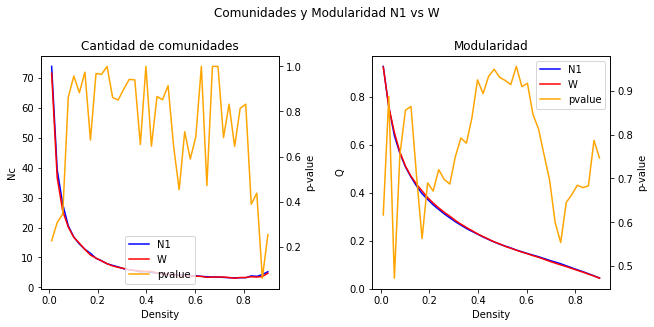

In [222]:
#Comunidades
df_ttest_comunidades = pd.DataFrame()
for den in df_comunidades_modularidad_sujeto_estado['densidad'].unique():
    muestra_n1 = df_comunidades_modularidad_sujeto_estado.loc[(df_comunidades_modularidad_sujeto_estado['densidad'] == den) & (df_comunidades_modularidad_sujeto_estado['estadio'] == 'N1')]['comunidades']
    muestra_n2 = df_comunidades_modularidad_sujeto_estado.loc[(df_comunidades_modularidad_sujeto_estado['densidad'] == den) & (df_comunidades_modularidad_sujeto_estado['estadio'] == 'N2')]['comunidades']
    muestra_n3 = df_comunidades_modularidad_sujeto_estado.loc[(df_comunidades_modularidad_sujeto_estado['densidad'] == den) & (df_comunidades_modularidad_sujeto_estado['estadio'] == 'N3')]['comunidades']
    muestra_w = df_comunidades_modularidad_sujeto_estado.loc[(df_comunidades_modularidad_sujeto_estado['densidad'] == den) & (df_comunidades_modularidad_sujeto_estado['estadio'] == 'W')]['comunidades']
    n1_mean = muestra_n1.mean()
    n2_mean = muestra_n2.mean()
    n3_mean = muestra_n3.mean()
    w_mean = muestra_w.mean()
    ttest_n1_w = ttest_ind(muestra_n1, muestra_w).pvalue
    ttest_n2_w = ttest_ind(muestra_n2, muestra_w).pvalue
    ttest_n3_w = ttest_ind(muestra_n3, muestra_w).pvalue
    
    df_ttest_comunidades = df_ttest_comunidades.append({'densidad': den, 'N1': n1_mean, 'N2': n2_mean, 'N3': n3_mean, 'W': w_mean,
                                'ttest_n1_w': ttest_n1_w, 'ttest_n2_w': ttest_n2_w, 'ttest_n3_w': ttest_n3_w, }, ignore_index = True)
    
#modularidad    
df_ttest_modularidad = pd.DataFrame()
for den in df_comunidades_modularidad_sujeto_estado['densidad'].unique():
    muestra_n1 = df_comunidades_modularidad_sujeto_estado.loc[(df_comunidades_modularidad_sujeto_estado['densidad'] == den) & (df_comunidades_modularidad_sujeto_estado['estadio'] == 'N1')]['modularidad']
    muestra_n2 = df_comunidades_modularidad_sujeto_estado.loc[(df_comunidades_modularidad_sujeto_estado['densidad'] == den) & (df_comunidades_modularidad_sujeto_estado['estadio'] == 'N2')]['modularidad']
    muestra_n3 = df_comunidades_modularidad_sujeto_estado.loc[(df_comunidades_modularidad_sujeto_estado['densidad'] == den) & (df_comunidades_modularidad_sujeto_estado['estadio'] == 'N3')]['modularidad']
    muestra_w = df_comunidades_modularidad_sujeto_estado.loc[(df_comunidades_modularidad_sujeto_estado['densidad'] == den) & (df_comunidades_modularidad_sujeto_estado['estadio'] == 'W')]['modularidad']
    n1_mean = muestra_n1.mean()
    n2_mean = muestra_n2.mean()
    n3_mean = muestra_n3.mean()
    w_mean = muestra_w.mean()
    ttest_n1_w = ttest_ind(muestra_n1, muestra_w).pvalue
    ttest_n2_w = ttest_ind(muestra_n2, muestra_w).pvalue
    ttest_n3_w = ttest_ind(muestra_n3, muestra_w).pvalue
    
    df_ttest_modularidad = df_ttest_modularidad.append({'densidad': den, 'N1': n1_mean, 'N2': n2_mean, 'N3': n3_mean, 'W': w_mean,
                                'ttest_n1_w': ttest_n1_w, 'ttest_n2_w': ttest_n2_w, 'ttest_n3_w': ttest_n3_w, }, ignore_index = True)
    

#graficos N1 vs W
N = 'N1'
ttest = 'ttest_n1_w'
color_N = 'blue'

plt.tight_layout()

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.suptitle('Comunidades y Modularidad ' + N +' vs W')

lns1 = plt.plot(pd.to_numeric(df_ttest_modularidad['densidad'], errors='coerce'), df_ttest_comunidades[N], label = N, color = color_N)
lns2 = plt.plot(pd.to_numeric(df_ttest_modularidad['densidad'], errors='coerce'), df_ttest_comunidades['W'], label = 'W', color = 'red')
plt.title('Cantidad de comunidades')
plt.xlabel('Density')
plt.ylabel('Nc')
ax2 = plt.twinx() 
lns3 = ax2.plot(pd.to_numeric(df_ttest_modularidad['densidad'], errors='coerce'), df_ttest_comunidades[ttest], label = 'pvalue', color = 'orange')
ax2.set_ylabel('p-value')
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
plt.legend(lns, labs, loc=0)
plt.tight_layout(pad=0.4, w_pad=5, h_pad=1.0)


plt.subplot(122)
lns1 = plt.plot(pd.to_numeric(df_ttest_modularidad['densidad'], errors='coerce'), df_ttest_modularidad[N], label = N, color = color_N)
lns2 = plt.plot(pd.to_numeric(df_ttest_modularidad['densidad'], errors='coerce'), df_ttest_modularidad['W'], label = 'W', color = 'red')
plt.xlabel('Density')
plt.ylabel('Q')
ax2 = plt.twinx()
lns3 = ax2.plot(pd.to_numeric(df_ttest_modularidad['densidad'], errors='coerce'), df_ttest_modularidad[ttest], label = 'pvalue', color = 'orange')
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
plt.legend(lns, labs, loc=0)
plt.title('Modularidad')
ax2.set_ylabel('p-value')
plt.tight_layout(w_pad=2, h_pad= 2, pad = 4)

<Figure size 432x288 with 0 Axes>

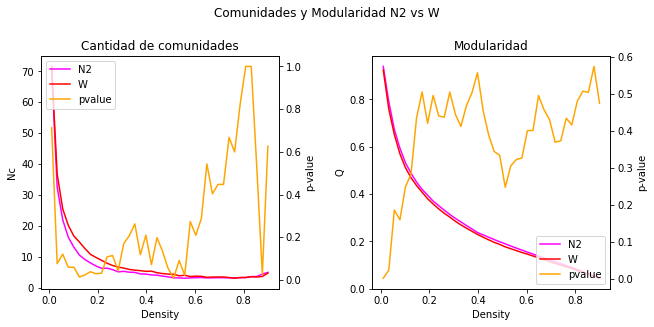

In [223]:
#graficos N2 vs W
N = 'N2'
ttest = 'ttest_n2_w'
color_N = 'magenta'

plt.tight_layout()

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.suptitle('Comunidades y Modularidad ' + N +' vs W')

lns1 = plt.plot(pd.to_numeric(pd.to_numeric(df_ttest_modularidad['densidad'], errors='coerce'), errors='coerce'), df_ttest_comunidades[N], label = N, color = color_N)
lns2 = plt.plot(pd.to_numeric(pd.to_numeric(df_ttest_modularidad['densidad'], errors='coerce'), errors='coerce'), df_ttest_comunidades['W'], label = 'W', color = 'red')
plt.title('Cantidad de comunidades')
plt.xlabel('Density')
plt.ylabel('Nc')
ax2 = plt.twinx() 
lns3 = ax2.plot(pd.to_numeric(pd.to_numeric(df_ttest_modularidad['densidad'], errors='coerce'), errors='coerce'), df_ttest_comunidades[ttest], label = 'pvalue', color = 'orange')
ax2.set_ylabel('p-value')


lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
plt.legend(lns, labs, loc=0)
plt.tight_layout(pad=0.4, w_pad=5, h_pad=1.0)


plt.subplot(122)
lns1 = plt.plot(pd.to_numeric(pd.to_numeric(df_ttest_modularidad['densidad'], errors='coerce'), errors='coerce'), df_ttest_modularidad[N], label = N, color = color_N)
lns2 = plt.plot(pd.to_numeric(pd.to_numeric(df_ttest_modularidad['densidad'], errors='coerce'), errors='coerce'), df_ttest_modularidad['W'], label = 'W', color = 'red')
plt.xlabel('Density')
plt.ylabel('Q')
ax2 = plt.twinx()
lns3 = ax2.plot(pd.to_numeric(pd.to_numeric(df_ttest_modularidad['densidad'], errors='coerce'), errors='coerce'), df_ttest_modularidad[ttest], label = 'pvalue', color = 'orange')
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
plt.legend(lns, labs, loc=0)
plt.title('Modularidad')
ax2.set_ylabel('p-value')
plt.tight_layout(w_pad=2, h_pad= 2, pad = 4)

<Figure size 432x288 with 0 Axes>

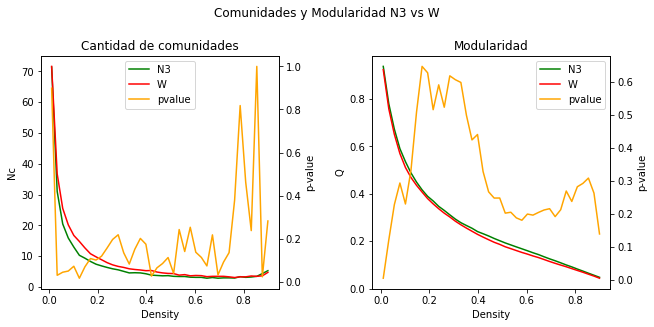

In [224]:
#graficos N3 vs W
N = 'N3'
ttest = 'ttest_n3_w'
color_N = 'green'

plt.tight_layout()

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.suptitle('Comunidades y Modularidad ' + N +' vs W')

lns1 = plt.plot(pd.to_numeric(df_ttest_modularidad['densidad'], errors='coerce'), df_ttest_comunidades[N], label = N, color = color_N)
lns2 = plt.plot(pd.to_numeric(df_ttest_modularidad['densidad'], errors='coerce'), df_ttest_comunidades['W'], label = 'W', color = 'red')
plt.title('Cantidad de comunidades')
plt.xlabel('Density')
plt.ylabel('Nc')
ax2 = plt.twinx() 
lns3 = ax2.plot(pd.to_numeric(df_ttest_modularidad['densidad'], errors='coerce'), df_ttest_comunidades[ttest], label = 'pvalue', color = 'orange')
ax2.set_ylabel('p-value')
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
plt.legend(lns, labs, loc=0)
plt.tight_layout(pad=0.4, w_pad=5, h_pad=1.0)


plt.subplot(122)
lns1 = plt.plot(pd.to_numeric(df_ttest_modularidad['densidad'], errors='coerce'), df_ttest_modularidad[N], label = N, color = color_N)
lns2 = plt.plot(pd.to_numeric(df_ttest_modularidad['densidad'], errors='coerce'), df_ttest_modularidad['W'], label = 'W', color = 'red')
plt.xlabel('Density')
plt.ylabel('Q')
ax2 = plt.twinx()
lns3 = ax2.plot(pd.to_numeric(df_ttest_modularidad['densidad'], errors='coerce'), df_ttest_modularidad[ttest], label = 'pvalue', color = 'orange')
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
plt.legend(lns, labs, loc=0)
plt.title('Modularidad')
ax2.set_ylabel('p-value')
plt.tight_layout(w_pad=2, h_pad= 2, pad = 4)

## 6. Tarea 4: Diferencias en la membresía para los diferentes estadíos
Para identificar diferencias significativas globales en la membresía de los nodos entre los
distintos estadíos del sueño (N1, N2 y N3), con el estadio despierto (W) se propone seguir el
procedimiento propuesto por Alexander-Bloch y colaboradores [Alexander-Bloch et al., 2012].
Se quiere saber si las comunidades encontradas en un estadio de sueño NX y las encontradas
en el cerebro despierto W son similares.
1. Se toman para todos los pares de sujetos en NX el Índice de Rand ajustado (adjustedfor-
chance Rand index).
2. Se toman para todos los pares de sujetos en W el Índice de Rand ajustado (adjustedfor-
chance Rand index).
3. Se promedian y se obtiene el Índice de Rand ajustado "within-group" observado (RIo).
Se lo graficar junto al error estandar de la media.
4. Se aleatorizan las etiquetas de los parece NX-W de forma que siempre esten todos los
sujetos en cada grupo pero con las etiquetas cambiadas, y se repiten los pasos 1-3 de
forma de obtener un Índice de Rand ajustado "within-group" permutado (RIp). Este
paso se repite Np veces generando una distribución empirica de valores de valores RIp.
5. El p-valor se calcula como la cantidad de permutaciones que dieron RIp > RIo divido
Np.

### Adaptado del whatsapp (falta revisarlo)

In [163]:
#Cuantas permutaciones voy a hacer. Cuantas más mejor pero más lento para calcular el rand_within_permutado
cantidad_permutaciones = 50
np.random.seed(288282)        


In [164]:
#Función para calcular rand entre particiones
def rand_within(particiones):

    rand_original = []
    for i in range(0, (len(particiones)-1)):
        vi = particiones[i, :]    
        for j in range((i+1), len(particiones)):
            vj = particiones[j, :]    
            rand_original.append(adjusted_rand_score(vi, vj))
    
    return rand_original

In [165]:
graphs = {}
for estadio in sujetos_df['estadio'].unique():    
    graphs[estadio] = {}
    for sujeto in sujetos_df['sujeto'].unique():
        sujeto_estadio_df = sujetos_df.loc[sujetos_df['estadio'] == estadio]
        sujeto_estadio_df = sujeto_estadio_df.loc[sujeto_estadio_df['sujeto'] == sujeto, sujetos_df.columns[0:116]]
        
        #armo grafos con distintas densidades para cada sujeto y estadio del sueño 
        graphs[estadio][sujeto] = tmatrix2graphsdict(sujeto_estadio_df, den_array)
        

In [172]:
#Recorro densidad por densidad, comparando Nx contra W para obtener el rand_within_observado. 
#Luego permuto los sujetos entre Nx y W cantidad_permutaciones de veces para obtener el rand_within_permutado
np.random.seed(12345)        
tipos = ["N1", "N2", "N3"]
rand_within_observado = {}
rand_within_permutado = {}
for tipo in tipos:
    rand_within_observado[tipo] = np.empty([0, 3])
    rand_within_permutado[tipo] = np.empty([0, 3])
for d in den_array:


    modulos = np.empty([0, 116])
    for tipo in sujetos_df['estadio'].unique():
        for sujeto in sujetos_df['sujeto'].unique():
            g = graphs[tipo][sujeto][str(d)]
            v = [v for v in community.best_partition(g).values()]
            modulos = np.append(modulos, [v], axis = 0)

    for tipo in range(0, 3):
        #print(tipos[tipo])
        rand_within_observado_actual = [d, np.mean([np.mean(rand_within(modulos[18*3:18*4-1, :])), np.mean(rand_within(modulos[18*tipo:18*(tipo+1)-1, :]))]), 0]
        #rand_within_observado[tipos[tipo]] = np.vstack((rand_within_observado[tipos[tipo]], [d, np.mean([np.mean(rand_within(modulos[18*3:18*4-1, :])), np.mean(rand_within(modulos[18*tipo:18*(tipo+1)-1, :]))])]))
        sujetos = list(range(18*tipo, 18*(tipo+1))) + list(range(54, 72))
        rand_shuffleado_aux = []
        pvalue = 0
        for s in range(0, cantidad_permutaciones):
            #if(s % 10 == 0):
            #    print(s)
            random.shuffle(sujetos)
            rand_shuffleado_aux.append(np.mean([np.mean(rand_within(modulos[sujetos[0:17], :])), np.mean(rand_within(modulos[sujetos[18:35], :]))]))
            if(rand_shuffleado_aux[len(rand_shuffleado_aux)-1] > rand_within_observado_actual[1]):
                pvalue = pvalue + 1
            
        rand_within_permutado[tipos[tipo]] = np.vstack((rand_within_permutado[tipos[tipo]], [d, np.mean(rand_shuffleado_aux), np.std(rand_shuffleado_aux)]))

        #Agregamos el pvalue
        rand_within_observado_actual[2] = pvalue/cantidad_permutaciones
        rand_within_observado[tipos[tipo]] = np.vstack((rand_within_observado[tipos[tipo]], rand_within_observado_actual))


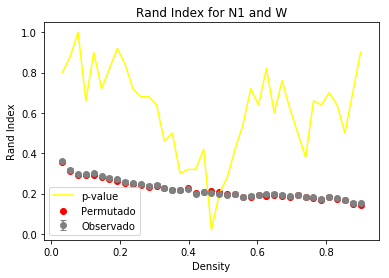

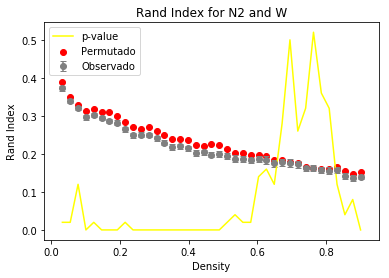

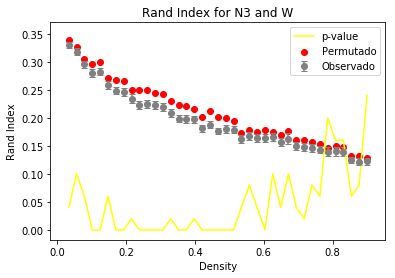

In [176]:
#Grafico para cada estadío de sueño el rand_within_observado y el rand_within_permutado

for tipo in tipos:
    plt.figure(figsize=(6, 4))
    plt.scatter(rand_within_observado[tipo][1:, 0], rand_within_observado[tipo][1:, 1], color = 'red')
    plt.errorbar(rand_within_permutado[tipo][1:, 0], rand_within_permutado[tipo][1:, 1], yerr=rand_within_permutado[tipo][1:, 2], capsize=3, color = 'grey', fmt='o')
    plt.plot(rand_within_observado[tipo][1:, 0], rand_within_observado[tipo][1:, 2], color = 'yellow')    
    plt.legend(['p-value', 'Permutado', 'Observado'])
    plt.title('Rand Index for ' + str(tipo) + ' and W')
    plt.xlabel('Density')
    plt.ylabel('Rand Index')
    
    